In [ ]:
from pyspark.sql.functions import col, count, when, mean, expr, array, explode, lit, stddev,sum as _sum, log
from pyspark.sql.types import IntegerType, FloatType, DoubleType, StringType
from pyspark.sql.functions import to_timestamp, substring, concat_ws, to_date
from pyspark.sql.functions import mean, stddev, count
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
clientID = dbutils.secrets.get(scope = "key-vault-scope", key = "ClientID")
secret = dbutils.secrets.get(scope = "key-vault-scope", key = "secret")
tenant = dbutils.secrets.get(scope = "key-vault-scope", key = "tenant")

In [ ]:
configs = {"fs.azure.account.auth.type": "OAuth",
"fs.azure.account.oauth.provider.type": "org.apache.hadoop.fs.azurebfs.oauth2.ClientCredsTokenProvider",
"fs.azure.account.oauth2.client.id": "ClientID",
"fs.azure.account.oauth2.client.secret": 'secret',
"fs.azure.account.oauth2.client.endpoint": "https://login.microsoftonline.com/tenant/oauth2/token"}


In [ ]:
dbutils.fs.mount(
source = "abfss://megafauna-data@martaprojectsa.dfs.core.windows.net", # contrainer@storageacc
mount_point = "/mnt/megafauna",
extra_configs = configs)

Out[3]: True

In [ ]:
%fs
ls "/mnt/megafauna"

path,name,size,modificationTime
dbfs:/mnt/megafauna/raw-data/,raw-data/,0,1719239995000
dbfs:/mnt/megafauna/transformed-data/,transformed-data/,0,1719240006000


# Step 1: Load the Data

we want to load two dataframes:

rovobservationdata
speciesdf

In [ ]:
rovobservationdata = (
    spark.read.format("csv")
    .option("delimiter", ",")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("/mnt/megafauna/raw-data/ROVObservationData.csv")
)

# Display the first 5 rows
rovobservationdata.limit(5).display()

DateTime,Easting,Northing,Depth,Temp,Sal,Oxy,Grain,Bedform,ac,ae,an,ap,as,ba,bas,bc,bgo,bgu,bi,bo,br,bs,ca,cc,cd,cg,ch,com,cp,cr,cs,cu,de,dp,eo,ep,eu,fej,fl,fo,fr,go,ha,hal,hb,hl,ii,io,ir,jde,jm,kb,kw,lc,lcom,li,ln,lo,ls,lss,lu,ly,lz,mc,mr,ms,mse,ol,ow,pa,pc,pem,pg,ph,pi,pl,po,pp,ppl,ps,pt,pyr,ra,rb,rh,ro,ru,rw,sa,sb,sc,scom,sd,se,sec,sh,shc,sl,sm,spo,sq,ss,st,te,th,ti,tr,unkss,vm,vr,vs,wfs,xl,ye,za,bl,hc,pe,py
2013-03-05T10:09:14.000+0000,474309.470706532,3635620.52327595,24.653,12.1313,33.5366,4.174,s2,lr,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-03-05T10:03:14.000+0000,474336.32882527,3635361.60918328,20.962,12.4446,33.5256,4.459,s2,lr,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-03-05T09:54:29.000+0000,474543.140760596,3635491.96680274,22.882,12.2266,33.5263,4.263,s2,hr,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-03-05T09:56:33.000+0000,474482.508857872,3635516.73382511,25.611,12.136,33.5403,4.154,s1,hr,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-03-05T10:14:34.000+0000,474291.036341439,3635766.84725211,28.129,12.1087,33.5308,4.149,s1,hr,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Step 2: Explore and Clean the Data

In [ ]:
# Check for null values and replace them with 0
rovobservationdata = rovobservationdata.fillna(0)

In [ ]:
# check if we have any unknown values in the dataset
unknown_counts = {}

# Iterate over each column and count "unknown" values
for column in rovobservationdata.columns:
    unknown_count = rovobservationdata.filter(col(column) == "unknown").count()
    unknown_counts[column] = unknown_count

# Display the counts of "unknown" values per column
for column, count in unknown_counts.items():
    print(f"Column '{column}' has {count} 'unknown' values.")

Column 'DateTime' has 0 'unknown' values.
Column 'Easting' has 0 'unknown' values.
Column 'Northing' has 0 'unknown' values.
Column 'Depth' has 0 'unknown' values.
Column 'Temp' has 0 'unknown' values.
Column 'Sal' has 0 'unknown' values.
Column 'Oxy' has 0 'unknown' values.
Column 'Grain' has 0 'unknown' values.
Column 'Bedform' has 0 'unknown' values.
Column 'ac' has 0 'unknown' values.
Column 'ae' has 0 'unknown' values.
Column 'an' has 0 'unknown' values.
Column 'ap' has 0 'unknown' values.
Column 'as' has 0 'unknown' values.
Column 'ba' has 0 'unknown' values.
Column 'bas' has 0 'unknown' values.
Column 'bc' has 0 'unknown' values.
Column 'bgo' has 0 'unknown' values.
Column 'bgu' has 0 'unknown' values.
Column 'bi' has 0 'unknown' values.
Column 'bo' has 0 'unknown' values.
Column 'br' has 0 'unknown' values.
Column 'bs' has 0 'unknown' values.
Column 'ca' has 0 'unknown' values.
Column 'cc' has 0 'unknown' values.
Column 'cd' has 0 'unknown' values.
Column 'cg' has 0 'unknown' v

In [ ]:
column_names = rovobservationdata.columns

# Print or display the column names
print(column_names)

['DateTime', 'Easting', 'Northing', 'Depth', 'Temp', 'Sal', 'Oxy', 'Grain', 'Bedform', 'ac', 'ae', 'an', 'ap', 'as', 'ba', 'bas', 'bc', 'bgo', 'bgu', 'bi', 'bo', 'br', 'bs', 'ca', 'cc', 'cd', 'cg', 'ch', 'com', 'cp', 'cr', 'cs', 'cu', 'de', 'dp', 'eo', 'ep', 'eu', 'fej', 'fl', 'fo', 'fr', 'go', 'ha', 'hal', 'hb', 'hl', 'ii', 'io', 'ir', 'jde', 'jm', 'kb', 'kw', 'lc', 'lcom', 'li', 'ln', 'lo', 'ls', 'lss', 'lu', 'ly', 'lz', 'mc', 'mr', 'ms', 'mse', 'ol', 'ow', 'pa', 'pc', 'pem', 'pg', 'ph', 'pi', 'pl', 'po', 'pp', 'ppl', 'ps', 'pt', 'pyr', 'ra', 'rb', 'rh', 'ro', 'ru', 'rw', 'sa', 'sb', 'sc', 'scom', 'sd', 'se', 'sec', 'sh', 'shc', 'sl', 'sm', 'spo', 'sq', 'ss', 'st', 'te', 'th', 'ti', 'tr', 'unkss', 'vm', 'vr', 'vs', 'wfs', 'xl', 'ye', 'za', 'bl', 'hc', 'pe', 'py']


# a) Analyze species distributions based on depth, temperature, and oxygen.
## Explore the data to ensure it is clean and that relevant columns such as Depth, Temp, and Oxy are of the appropriate numeric type (double, float, etc.). If necessary, perform cleaning operations such as handling null or incorrect values.

In [ ]:
# Verify the schema to ensure that the relevant columns are numeric
rovobservationdata.printSchema()

# If necessary, convert columns to numeric types
rovobservationdata = rovobservationdata.withColumn("Depth", col("Depth").cast("double"))
rovobservationdata = rovobservationdata.withColumn("Temp", col("Temp").cast("double"))
rovobservationdata = rovobservationdata.withColumn("Oxy", col("Oxy").cast("double"))

# Discard rows with null values in important columns
rovobservationdata = rovobservationdata.dropna(subset=["Depth", "Temp", "Oxy"])

root
 |-- DateTime: timestamp (nullable = true)
 |-- Easting: double (nullable = false)
 |-- Northing: double (nullable = false)
 |-- Depth: double (nullable = false)
 |-- Temp: double (nullable = false)
 |-- Sal: double (nullable = false)
 |-- Oxy: double (nullable = false)
 |-- Grain: string (nullable = true)
 |-- Bedform: string (nullable = true)
 |-- ac: integer (nullable = true)
 |-- ae: integer (nullable = true)
 |-- an: integer (nullable = true)
 |-- ap: integer (nullable = true)
 |-- as: integer (nullable = true)
 |-- ba: integer (nullable = true)
 |-- bas: integer (nullable = true)
 |-- bc: integer (nullable = true)
 |-- bgo: integer (nullable = true)
 |-- bgu: integer (nullable = true)
 |-- bi: integer (nullable = true)
 |-- bo: integer (nullable = true)
 |-- br: integer (nullable = true)
 |-- bs: integer (nullable = true)
 |-- ca: integer (nullable = true)
 |-- cc: integer (nullable = true)
 |-- cd: integer (nullable = true)
 |-- cg: integer (nullable = true)
 |-- ch: intege

# Step 3: Distribution Analysis

In [ ]:
# Statistical Summary of the Variables of Interest
rovobservationdata.select("Depth", "Temp", "Oxy").describe().show()

+-------+------------------+------------------+------------------+
|summary|             Depth|              Temp|               Oxy|
+-------+------------------+------------------+------------------+
|  count|              2404|              2404|              2404|
|   mean| 51.14148419301156|11.591623086522528| 3.707995008319471|
| stddev|23.648458324812804|1.1505305413100422|0.9842199561864603|
|    min|             9.454|            9.5947|             1.877|
|    max|            146.51|            16.151|             6.198|
+-------+------------------+------------------+------------------+



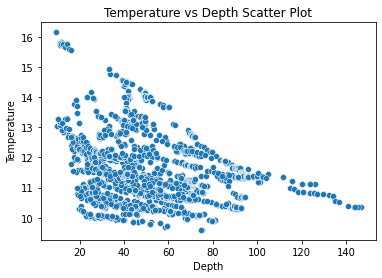

In [ ]:
sns.scatterplot(x="Depth", y="Temp", data=rovobservationdata.toPandas())
plt.title('Temperature vs Depth Scatter Plot')
plt.xlabel('Depth')
plt.ylabel('Temperature')
plt.show()

The scatter plot suggests that temperature generally decreases as depth increases, with significant variability in the data. This visualization helps to understand the relationship and distribution between depth and temperature in the dataset

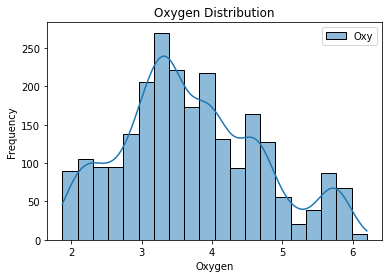

In [ ]:
# Oxygen Distribution
sns.histplot(rovobservationdata.select("Oxy").toPandas(), bins=20, kde=True)
plt.title('Oxygen Distribution')
plt.xlabel('Oxygen')
plt.ylabel('Frequency')
plt.show()

2.5 to 4.0 units of oxygen: This is the most common range where the highest frequency of observations of marine fauna occurs.

# Step 4: Relationship Analysis

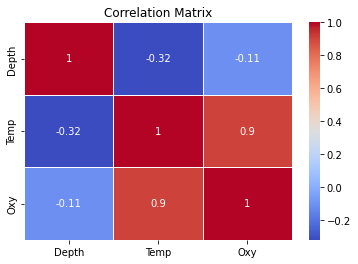

In [ ]:
# Correlation matrix of the diffetent variables
correlation_matrix = rovobservationdata.select("Depth", "Temp", "Oxy").toPandas().corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

The strongest correlation in the matrix is the positive correlation between the second and third variables (0.9), indicating a significant positive relationship.
The moderate negative correlation between the first and second variables (-0.32) suggests an inverse relationship, though not as strong.
There is a positive correlation between temperature and oxygen, and an inverse correlation between depth and temperature.

# Species Mobility Analysis
### Objective: Evaluate how species mobility affects their distribution and tolerance to oxygen conditions.
### Steps:
 - Classify species based on their mobility (sessile, mobile, highly mobile) using species data.
 - Compare oxygen distributions and tolerances among these categories.
 - Use statistical analyses to evaluate significant differences in distribution and oxygen tolerance.

### a) Classify the species based on their mobility. Integrate this classification with the ROV observation data. Calculate the average oxygen levels for each mobility classification. Visualize the distribution of oxygen levels for each mobility classification.

In [ ]:
species_df = (
    spark.read.format("csv")
    .option("delimiter", ",")
    .option("header", "true")
    .option("inferSchema", "true")
    .load("/mnt/megafauna/raw-data/SpeciesMetadata.csv")
)

# Display the first 5 rows
species_df.limit(5).display()

SpeciesCode,Mobility,SpeciesName,CommonName,MajorTaxa,Group,QuantScale
ac,s,Acanthoptilum sp.,Sea Pen,Cnidaria,Virgulariid,individuals
ae,m,Mediaster aequalis,Vermillion seastar,Echinodermata,Asteroid,individuals
an,s,Parazoanthus lucificum,Luminescent Parazoanthid,Cnidaria,Parazoanthid,individuals
ap,s,Adelogorgia phyllosclera,Orange Gorgonian,Cnidaria,Gorgoniid,individuals
as,m,Astropecten sp.,Sand Star,Echinodermata,Asteroid,individuals


In [ ]:
# Create a dictionary for mobility classifications from species data
mobility_dict = {row['SpeciesCode']: row['Mobility'] for row in species_df.collect()}

# Add mobility classification to ROV observation data
for species_code, mobility in mobility_dict.items():
    if species_code in rovobservationdata.columns:
        rovobservationdata = rovobservationdata.withColumn(f"{species_code}_mobility", when(col(species_code) > 0, mobility).otherwise(None))

# Melt the DataFrame
mobility_columns = [f"{species_code}_mobility" for species_code in mobility_dict.keys() if f"{species_code}_mobility" in rovobservationdata.columns]
melted_df = rovobservationdata.select(col("Oxy"), explode(array([col(c).alias("mobility") for c in mobility_columns])).alias("mobility"))

# Filter and calculate average oxygen levels for each mobility classification
sessile_df = melted_df.filter(col("mobility") == 's').filter(col("Oxy").isNotNull() & (col("Oxy") > 0))
mobile_df = melted_df.filter(col("mobility") == 'm').filter(col("Oxy").isNotNull() & (col("Oxy") > 0))
highly_mobile_df = melted_df.filter(col("mobility") == 'hm').filter(col("Oxy").isNotNull() & (col("Oxy") > 0))

# Calculate average oxygen levels
avg_oxy_sessile = sessile_df.agg(mean("Oxy")).first()[0]
avg_oxy_mobile = mobile_df.agg(mean("Oxy")).first()[0]
avg_oxy_highly_mobile = highly_mobile_df.agg(mean("Oxy")).first()[0]

average_oxygen_levels = {
    "sessile": avg_oxy_sessile,
    "mobile": avg_oxy_mobile,
    "highly_mobile": avg_oxy_highly_mobile
}

print(average_oxygen_levels)

{'sessile': 3.6170446976336503, 'mobile': 3.570479321753514, 'highly_mobile': 3.6500532915360577}



### b) Compare the distributions and tolerances of oxygen between these categories

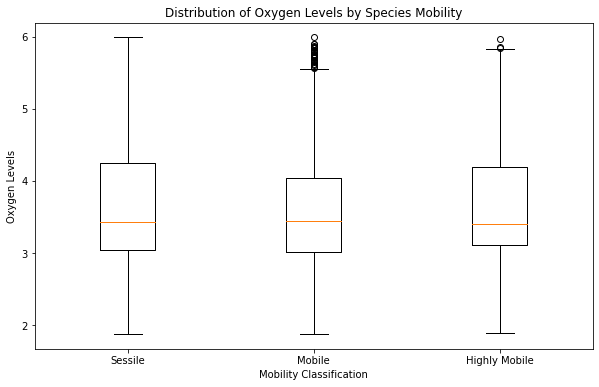

In [ ]:
# Collect oxygen levels for each mobility classification
sessile_oxygen_levels = [row['Oxy'] for row in sessile_df.collect()]
mobile_oxygen_levels = [row['Oxy'] for row in mobile_df.collect()]
highly_mobile_oxygen_levels = [row['Oxy'] for row in highly_mobile_df.collect()]

# Create a boxplot for the distribution of oxygen levels
data = [sessile_oxygen_levels, mobile_oxygen_levels, highly_mobile_oxygen_levels]
labels = ['Sessile', 'Mobile', 'Highly Mobile']

plt.figure(figsize=(10, 6))
plt.boxplot(data, labels=labels)
plt.xlabel('Mobility Classification')
plt.ylabel('Oxygen Levels')
plt.title('Distribution of Oxygen Levels by Species Mobility')
plt.show()

The median oxygen levels are relatively similar across all three mobility categories. The IQRs are also similar, suggesting that the range of typical oxygen levels is fairly consistent across mobility categories. The presence of outliers in the mobile and highly mobile categories indicates that some species in these categories can tolerate higher oxygen levels than most. The similarity in median oxygen levels suggests that oxygen tolerance might not be significantly influenced by species mobility. However, the outliers in mobile and highly mobile species indicate that these species might occasionally be found in environments with higher oxygen levels, possibly due to their ability to move and seek more optimal conditions.

### c) Use statistical analyses to evaluate significant differences in distribution and oxygen tolerance.

In [ ]:
# Calculate descriptive statistics
sessile_stats = sessile_df.agg(mean("Oxy").alias("mean"), stddev("Oxy").alias("stddev"), count("Oxy").alias("count"))
mobile_stats = mobile_df.agg(mean("Oxy").alias("mean"), stddev("Oxy").alias("stddev"), count("Oxy").alias("count"))
highly_mobile_stats = highly_mobile_df.agg(mean("Oxy").alias("mean"), stddev("Oxy").alias("stddev"), count("Oxy").alias("count"))

sessile_stats.show()
mobile_stats.show()
highly_mobile_stats.show()


+------------------+------------------+-----+
|              mean|            stddev|count|
+------------------+------------------+-----+
|3.6170446976336503|0.9619668460083771| 2282|
+------------------+------------------+-----+

+-----------------+------------------+-----+
|             mean|            stddev|count|
+-----------------+------------------+-----+
|3.570479321753514|0.8608083920971481| 2418|
+-----------------+------------------+-----+

+------------------+------------------+-----+
|              mean|            stddev|count|
+------------------+------------------+-----+
|3.6500532915360577|0.9082754305562265|  638|
+------------------+------------------+-----+



**Interpretation: Comparison of Means:**

The mean oxygen levels are quite similar among the three categories, with mobile species showing a slightly lower mean and sessile and highly mobile species having slightly higher and closer means to each other. This suggests that differences in species mobility do not have a significant impact on the average oxygen levels they encounter. 

Variability (Standard Deviation):

The standard deviation is highest for sessile species (0.962) and lowest for mobile species (0.861), with highly mobile species in the middle (0.908). This indicates that oxygen levels are more consistent (less variable) for mobile species compared to sessile and highly mobile species. Number of Observations:

There are more observations for mobile (2418) and sessile (2282) species compared to highly mobile species (638). This could suggest greater representativeness of mobile and sessile species in the collected data or greater difficulty in observing and recording highly mobile species. 

**Conclusion**: The results indicate that, although there are small differences in average oxygen levels and the variability of these levels among different mobility categories, overall, species with different types of mobility show relatively similar oxygen levels. Mobile species tend to have more consistent oxygen levels, while sessile and highly mobile species exhibit greater variability in oxygen levels.

# Habitat Evaluation
Objective: Examine how different habitat types affect species distribution and their exposure to oxygen.
Steps:
- Classify observations by habitat type using the available information.
- Analyze species abundance in different habitats and its relationship with oxygen conditions.


### a) Classify observations by habitat type

In [ ]:
def classify_habitat(grain, bedform):
    if grain == 's2' and bedform in ['lr', 'hr']:
        return 'Sandy'
    elif grain == 's1' and bedform in ['hr']:
        return 'Rocky'
    elif grain == 'm' and bedform in ['f', 'sv']:
        return 'Mudflat'
    elif grain == 's2' and bedform in ['f', 'c']:
        return 'Soft Sandy'
    elif grain == 'm' and bedform in ['b']:
        return 'Mud Bank'
    else:
        return 'Other'

In [ ]:
# Define the UDF for habitat classification
classify_habitat_udf = udf(classify_habitat, StringType())

# Apply the habitat classification
rov_df = rovobservationdata.withColumn("Habitat", classify_habitat_udf(col("Grain"), col("Bedform")))

# Show the updated DataFrame
rov_df.limit(5).display()

DateTime,Easting,Northing,Depth,Temp,Sal,Oxy,Grain,Bedform,ac,ae,an,ap,as,ba,bas,bc,bgo,bgu,bi,bo,br,bs,ca,cc,cd,cg,ch,com,cp,cr,cs,cu,de,dp,eo,ep,eu,fej,fl,fo,fr,go,ha,hal,hb,hl,ii,io,ir,jde,jm,kb,kw,lc,lcom,li,ln,lo,ls,lss,lu,ly,lz,mc,mr,ms,mse,ol,ow,pa,pc,pem,pg,ph,pi,pl,po,pp,ppl,ps,pt,pyr,ra,rb,rh,ro,ru,rw,sa,sb,sc,scom,sd,se,sec,sh,shc,sl,sm,spo,sq,ss,st,te,th,ti,tr,unkss,vm,vr,vs,wfs,xl,ye,za,bl,hc,pe,py,ac_mobility,ae_mobility,an_mobility,ap_mobility,as_mobility,ba_mobility,bas_mobility,bc_mobility,bgo_mobility,bgu_mobility,bi_mobility,bl_mobility,bo_mobility,br_mobility,bs_mobility,ca_mobility,cc_mobility,cd_mobility,cg_mobility,ch_mobility,com_mobility,cp_mobility,cr_mobility,cs_mobility,cu_mobility,de_mobility,dp_mobility,eo_mobility,ep_mobility,eu_mobility,fej_mobility,fl_mobility,fo_mobility,fr_mobility,go_mobility,ha_mobility,hal_mobility,hb_mobility,hc_mobility,hl_mobility,ii_mobility,io_mobility,ir_mobility,jde_mobility,jm_mobility,kb_mobility,kw_mobility,lc_mobility,lcom_mobility,li_mobility,ln_mobility,lo_mobility,ls_mobility,lss_mobility,lu_mobility,ly_mobility,lz_mobility,mc_mobility,mr_mobility,ms_mobility,mse_mobility,ol_mobility,ow_mobility,pa_mobility,pc_mobility,pe_mobility,pem_mobility,pg_mobility,ph_mobility,pi_mobility,pl_mobility,po_mobility,pp_mobility,ppl_mobility,ps_mobility,pt_mobility,py_mobility,pyr_mobility,ra_mobility,rb_mobility,rh_mobility,ro_mobility,ru_mobility,rw_mobility,sa_mobility,sb_mobility,sc_mobility,scom_mobility,sd_mobility,se_mobility,sec_mobility,sh_mobility,shc_mobility,sl_mobility,sm_mobility,spo_mobility,sq_mobility,ss_mobility,st_mobility,te_mobility,th_mobility,ti_mobility,tr_mobility,unkss_mobility,vm_mobility,vr_mobility,vs_mobility,wfs_mobility,xl_mobility,ye_mobility,za_mobility,Habitat
2013-03-05T10:09:14.000+0000,474309.470706532,3635620.52327595,24.653,12.1313,33.5366,4.174,s2,lr,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,Sandy
2013-03-05T10:03:14.000+0000,474336.32882527,3635361.60918328,20.962,12.4446,33.5256,4.459,s2,lr,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,Sandy
2013-03-05T09:54:29.000+0000,474543.140760596,3635491.96680274,22.882,12.2266,33.5263,4.263,s2,hr,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,n

Habitat: Rocky, Stats: {'mean_oxygen': 3.7590420560747697, 'stddev_oxygen': 0.8489945078028011, 'count_oxygen': 214}
Habitat: Mud Bank, Stats: {'mean_oxygen': 3.2187647058823528, 'stddev_oxygen': 0.3759478902407494, 'count_oxygen': 17}
Habitat: Mudflat, Stats: {'mean_oxygen': 3.6452516556291346, 'stddev_oxygen': 0.7755397753201079, 'count_oxygen': 302}
Habitat: Sandy, Stats: {'mean_oxygen': 3.902989417989416, 'stddev_oxygen': 0.896776425500935, 'count_oxygen': 189}
Habitat: Soft Sandy, Stats: {'mean_oxygen': 3.5815518518518568, 'stddev_oxygen': 1.0117119383173134, 'count_oxygen': 810}
Habitat: Other, Stats: {'mean_oxygen': 3.8019243119266006, 'stddev_oxygen': 1.0596622953836996, 'count_oxygen': 872}


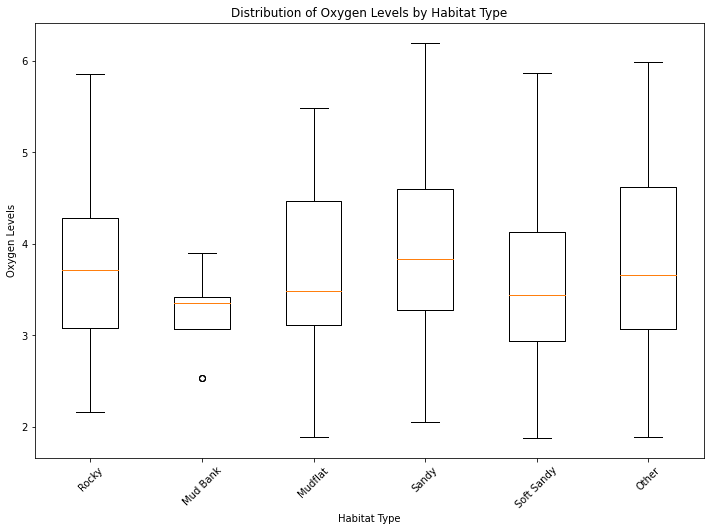

In [ ]:
# Filter observations by habitat type
habitats = rov_df.select("Habitat").distinct().rdd.flatMap(lambda x: x).collect()

# Create a dictionary to store statistics by habitat
habitat_stats = {}

for habitat in habitats:
    habitat_df = rov_df.filter(col("Habitat") == habitat)
    
    # Calculate descriptive statistics for oxygen
    stats = habitat_df.agg(
        mean("Oxy").alias("mean_oxygen"),
        stddev("Oxy").alias("stddev_oxygen"),
        count("Oxy").alias("count_oxygen")
    ).collect()[0]
    
    habitat_stats[habitat] = {
        "mean_oxygen": stats["mean_oxygen"],
        "stddev_oxygen": stats["stddev_oxygen"],
        "count_oxygen": stats["count_oxygen"]
    }

# Display the statistics by habitat
for habitat, stats in habitat_stats.items():
    print(f"Habitat: {habitat}, Stats: {stats}")

# Collect data for visualization
oxygen_levels_by_habitat = {habitat: rov_df.filter(col("Habitat") == habitat).select("Oxy").rdd.flatMap(lambda x: x).collect() for habitat in habitats}

# Create a boxplot for the distribution of oxygen levels by habitat type

data = [oxygen_levels for oxygen_levels in oxygen_levels_by_habitat.values()]
labels = [habitat for habitat in oxygen_levels_by_habitat.keys()]

plt.figure(figsize=(12, 8))
plt.boxplot(data, labels=labels)
plt.xlabel('Habitat Type')
plt.ylabel('Oxygen Levels')
plt.title('Distribution of Oxygen Levels by Habitat Type')
plt.xticks(rotation=45)
plt.show()

The Mud Bank habitat type has the least oxygen, as indicated by the lowest median line in the box plot.


### b) Analyze species abundance in different habitats and its relationship with oxygen conditions.

In [ ]:
# List of non-species columns
non_species_columns = ['DateTime', 'Easting', 'Northing', 'Depth', 'Temp', 'Sal', 'Oxy', 'Grain', 'Bedform', 'Habitat']

# Identify species columns in rov_df
species_columns = [col for col in rov_df.columns if col not in non_species_columns]

# Build the aggregation expressions for species abundance
agg_exprs = [_sum(col(species)).alias(species) for species in species_columns]

# Aggregate species counts by habitat
species_abundance_by_habitat = rov_df.groupBy("Habitat").agg(*agg_exprs)

# Calculate mean and standard deviation of oxygen levels by habitat
oxygen_stats_by_habitat = rov_df.groupBy("Habitat").agg(
    mean("Oxy").alias("mean_oxygen"),
    stddev("Oxy").alias("stddev_oxygen")
)

# Join species abundance with oxygen stats
abundance_oxygen_stats = species_abundance_by_habitat.join(oxygen_stats_by_habitat, "Habitat")

# Show the combined stats
abundance_oxygen_stats.display()

Habitat,ac,ae,an,ap,as,ba,bas,bc,bgo,bgu,bi,bo,br,bs,ca,cc,cd,cg,ch,com,cp,cr,cs,cu,de,dp,eo,ep,eu,fej,fl,fo,fr,go,ha,hal,hb,hl,ii,io,ir,jde,jm,kb,kw,lc,lcom,li,ln,lo,ls,lss,lu,ly,lz,mc,mr,ms,mse,ol,ow,pa,pc,pem,pg,ph,pi,pl,po,pp,ppl,ps,pt,pyr,ra,rb,rh,ro,ru,rw,sa,sb,sc,scom,sd,se,sec,sh,shc,sl,sm,spo,sq,ss,st,te,th,ti,tr,unkss,vm,vr,vs,wfs,xl,ye,za,bl,hc,pe,py,ac_mobility,ae_mobility,an_mobility,ap_mobility,as_mobility,ba_mobility,bas_mobility,bc_mobility,bgo_mobility,bgu_mobility,bi_mobility,bl_mobility,bo_mobility,br_mobility,bs_mobility,ca_mobility,cc_mobility,cd_mobility,cg_mobility,ch_mobility,com_mobility,cp_mobility,cr_mobility,cs_mobility,cu_mobility,de_mobility,dp_mobility,eo_mobility,ep_mobility,eu_mobility,fej_mobility,fl_mobility,fo_mobility,fr_mobility,go_mobility,ha_mobility,hal_mobility,hb_mobility,hc_mobility,hl_mobility,ii_mobility,io_mobility,ir_mobility,jde_mobility,jm_mobility,kb_mobility,kw_mobility,lc_mobility,lcom_mobility,li_mobility,ln_mobility,lo_mobility,ls_mobility,lss_mobility,lu_mobility,ly_mobility,lz_mobility,mc_mobility,mr_mobility,ms_mobility,mse_mobility,ol_mobility,ow_mobility,pa_mobility,pc_mobility,pe_mobility,pem_mobility,pg_mobility,ph_mobility,pi_mobility,pl_mobility,po_mobility,pp_mobility,ppl_mobility,ps_mobility,pt_mobility,py_mobility,pyr_mobility,ra_mobility,rb_mobility,rh_mobility,ro_mobility,ru_mobility,rw_mobility,sa_mobility,sb_mobility,sc_mobility,scom_mobility,sd_mobility,se_mobility,sec_mobility,sh_mobility,shc_mobility,sl_mobility,sm_mobility,spo_mobility,sq_mobility,ss_mobility,st_mobility,te_mobility,th_mobility,ti_mobility,tr_mobility,unkss_mobility,vm_mobility,vr_mobility,vs_mobility,wfs_mobility,xl_mobility,ye_mobility,za_mobility,mean_oxygen,stddev_oxygen
Rocky,0,0,0,0,87,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,82,115,0,0,0,0,0,0,0,0,0,0,0,0,46,72,0,0,0,0,1.0,0,0,2,0,0,2,0,23,24,6,0,5.0,0,20,0,0,1,2,0,7,0,0,5,0,1,0,0,3,1,4,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,32,0,6,0,0,0,2,0,0,0,0,7,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.7590420560747697,0.8489945078028011
Mud Bank,0,0,7,140,0,0,1,0,0,0,0,0,0,2,0,0,7,0,0,0,0,0,0,22,0,0,0,0,3,0,1,0,0,0,0,0,17,0,0,0,8,0,0,0,0.0,0,0,0,0,4,0,0,0,2,0,0,0.0,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,2,0,0,0,11,2,0,0,0,0,0,1,0,0,0,0,0,0,2,11,0,1,0,0,5,0,0,0,0,0,0,0,0,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3.2187647058823528,0.3759478902407494
Mudflat,12,2,21,194,2,1,0,0,1,0,14,0,0,3,0,0,16,0,17,9,0,0,4,42,0,3,46,0,10,0,3,0,0,0,0,0,31,0,136,383,0,0,0,0,4.0,0,0,0,0,5,0,0,14,334,37,0,7.0,0,0,0,0,0,51,4,0,2,0,4,0,7,0,1,2,0,0,0,0,1,1,0,0,1,5,6,0,0,0,0,0,0,0,0,0,0,25,0,108,0,0,1,15,3,0,0,0,0,0,0,0,0,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,nul

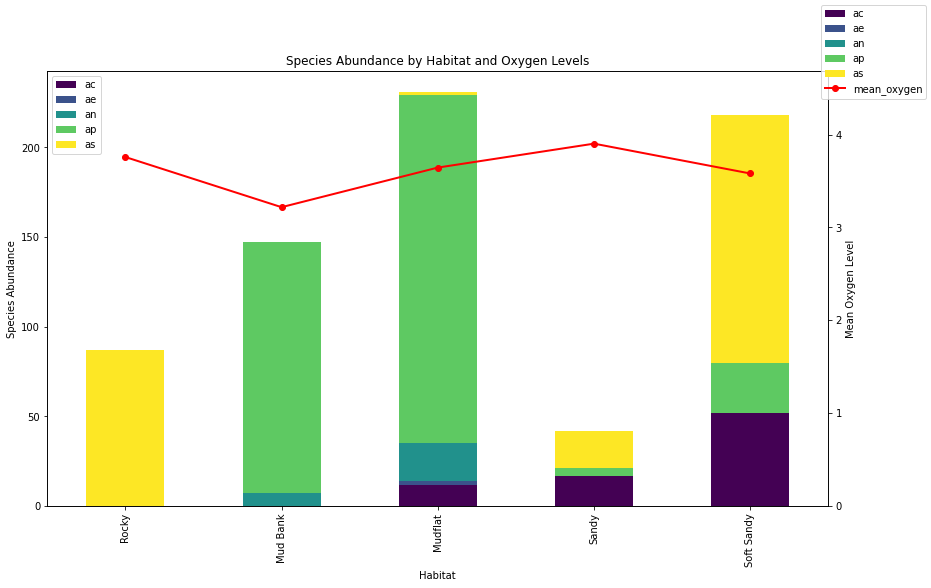

In [ ]:
# List of non-species columns
non_species_columns = ['DateTime', 'Easting', 'Northing', 'Depth', 'Temp', 'Sal', 'Oxy', 'Grain', 'Bedform', 'Habitat']

# Identify species columns in rov_df
species_columns = [col for col in rov_df.columns if col not in non_species_columns]

# Build the aggregation expressions for species abundance
agg_exprs = [_sum(col(species)).alias(species) for species in species_columns]

# Aggregate species counts by habitat
species_abundance_by_habitat = rov_df.groupBy("Habitat").agg(*agg_exprs)

# Calculate mean and standard deviation of oxygen levels by habitat
oxygen_stats_by_habitat = rov_df.groupBy("Habitat").agg(
    mean("Oxy").alias("mean_oxygen"),
    stddev("Oxy").alias("stddev_oxygen")
)

# Join species abundance with oxygen stats
abundance_oxygen_stats = species_abundance_by_habitat.join(oxygen_stats_by_habitat, "Habitat")

# Convert to Pandas DataFrame for plotting
abundance_oxygen_stats_pandas = abundance_oxygen_stats.toPandas()

# Filter out the "other" habitat, assuming "Other" is the label
abundance_oxygen_stats_pandas = abundance_oxygen_stats_pandas[abundance_oxygen_stats_pandas['Habitat'] != 'Other']

# Select a subset of species columns for better clarity
subset_species_columns = species_columns[:5]  # Adjust the number as needed

# Plotting species abundance and oxygen statistics for the subset
fig, ax1 = plt.subplots(figsize=(14, 8))

# Bar plot for species abundance by habitat
abundance_oxygen_stats_pandas.set_index('Habitat')[subset_species_columns].plot(kind='bar', stacked=True, ax=ax1, colormap='viridis')

ax1.set_ylabel('Species Abundance')
ax1.set_xlabel('Habitat')
ax1.set_title('Species Abundance by Habitat and Oxygen Levels')

# Line plot for mean oxygen levels by habitat
ax2 = ax1.twinx()
abundance_oxygen_stats_pandas.set_index('Habitat')['mean_oxygen'].plot(kind='line', color='red', marker='o', ax=ax2, linewidth=2)

ax2.set_ylabel('Mean Oxygen Level')
ax2.set_ylim(0, abundance_oxygen_stats_pandas['mean_oxygen'].max() * 1.2)

plt.show()

There is no clear direct correlation between species abundance and mean oxygen levels based on this chart alone. The habitat with the highest species abundance does not have the highest mean oxygen level, suggesting other factors might influence species distribution and abundance.